<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nbody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install notebook-video-writer tensor-canvas

In [2]:
import jax.numpy as jnp
from jax import jit
from jax import vmap
import jax
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorcanvas as tc
from notebook_video_writer import VideoWriter

In [3]:
#@title VideoWriter
#VideoWriter from Alexander Mordvintsev 
#https://colab.research.google.com/github/znah/notebooks/blob/master/external_colab_snippets.ipynb

import os
import numpy as np
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [4]:
def draw_sim(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  canvas = jnp.zeros((grid_r, grid_r, 3))
  col = opacity*jnp.array([1.0,0.0,0.0])
  # would be interesting to use jax.experimental.loops for these
  for part_p, part_v in zip(parts_pos, parts_vel):
    canvas = tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canvas)
  return canvas

In [5]:
def draw_sim_par(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  col = opacity*jnp.array([1.0,0.0,0.0])
  draw_single = lambda part_p, canv: tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canv)
  draw_all = vmap(draw_single)
  return draw_all(parts_pos, jnp.zeros((parts_pos.shape[0], grid_r, grid_r, 3))).sum(0)

In [6]:
def compute_forces(pos, scale, eps=0.1):
  a, b = jnp.expand_dims(pos, 1), jnp.expand_dims(pos, 0)
  diff = a - b
  dist = (diff * diff).sum(axis=-1) ** 0.5
  dist = jnp.expand_dims(dist, 2)
  force = diff / ((dist * scale) ** 3 + eps)
  return force.sum(0)

fast_compute_forces = jit(compute_forces)

In [7]:
def sim_update_force(parts_pos, parts_vel, t_delta=0.05, scale=5, repel_mag=0.1, center_mag=2.5, steps=10, damp=0.99):
  p_p = jnp.array(parts_pos)
  p_v = jnp.array(parts_vel)
  # jax.experimental.loops
  for _ in range(steps):
    p_p = p_p + t_delta * p_v
    force = fast_compute_forces(p_p, scale)
    center_diff = p_p-0.5
    centering_force = center_diff / ((center_diff ** 2).sum() ** 0.5)
    p_v = damp * p_v - t_delta * (force * repel_mag + centering_force * center_mag)
  return p_p, p_v

In [8]:
def make_init_state(p_count):
  return random.rand(p_count, 2), random.rand(p_count, 2)-0.5

In [9]:
fast_draw = jit(draw_sim, static_argnums=(2,))
fast_draw_par = jit(draw_sim_par, static_argnums=(2,))
fast_sim_update_force = jit(sim_update_force, static_argnames=('steps'))

100%|██████████| 1000/1000 [00:00<00:00, 2532.00it/s]


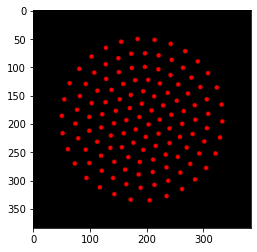

In [10]:
p_state, v_state = make_init_state(128)
v_state *= 0
grid_res = 384
for i in tqdm(range(1000)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=4.0))

100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


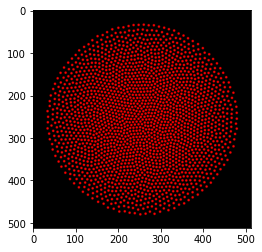

In [11]:
p_state, v_state = make_init_state(2048)
v_state *= 0
grid_res = 512
for i in tqdm(range(100)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=40, center_mag=0.5, repel_mag=0.05, damp=0.997, steps=20)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=3.0))


In [23]:
render_video = False

In [24]:
if render_video:
  p_state, v_state = make_init_state(128)
  v_state *= 0
  grid_res = 384
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)

In [14]:
if render_video:
  p_state, v_state = make_init_state(512)
  v_state *= 0
  grid_res = 256
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, opacity=0.5, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=20, center_mag=0.5, repel_mag=0.05, damp=0.998, steps=4)

In [15]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [16]:
p_test = 50
res_test = 512

In [17]:
%%timeit
draw_sim(*make_init_state(p_test), res_test)

579 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
draw_sim_par(*make_init_state(p_test), res_test)

632 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
fast_draw(*make_init_state(p_test), res_test)

28.9 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
fast_draw_par(*make_init_state(p_test), res_test)

79.6 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
